In [ ]:
import pandas as pd

# Load data
df = pd.read_excel("third_mockup.xlsx")

# Move 'year' to the front
cols = df.columns.tolist()
if 'year' in cols:
    cols.insert(0, cols.pop(cols.index('year')))
df = df[cols]

# Display structure
print("Data shape:", df.shape)
print("Columns:", df.columns.tolist())

Data shape: (67963, 189)
Columns: ['year', 'country', 'item', 'mean_cov_1', 'mean_cov_2', 'mean_cov_3', 'mean_cov_4', 'mean_cov_5', 'mean_cov_6', 'mean_cov_7', 'mean_cov_8', 'mean_cov_9', 'mean_cov_10', 'mean_cov_11', 'mean_cov_12', 'mean_cov_13', 'mean_cov_14', 'mean_cov_15', 'mean_cov_16', 'mean_cov_17', 'rain_1', 'rain_2', 'rain_3', 'rain_4', 'rain_5', 'rain_6', 'rain_7', 'rain_8', 'rain_9', 'rain_10', 'rain_11', 'rain_12', 'snow_1', 'snow_2', 'snow_3', 'snow_4', 'snow_5', 'snow_6', 'snow_7', 'snow_8', 'snow_9', 'snow_10', 'snow_11', 'snow_12', 'esoil_1', 'esoil_2', 'esoil_3', 'esoil_4', 'esoil_5', 'esoil_6', 'esoil_7', 'esoil_8', 'esoil_9', 'esoil_10', 'esoil_11', 'esoil_12', 'soilmoisture_0_10_1', 'soilmoisture_0_10_2', 'soilmoisture_0_10_3', 'soilmoisture_0_10_4', 'soilmoisture_0_10_5', 'soilmoisture_0_10_6', 'soilmoisture_0_10_7', 'soilmoisture_0_10_8', 'soilmoisture_0_10_9', 'soilmoisture_0_10_10', 'soilmoisture_0_10_11', 'soilmoisture_0_10_12', 'soilmoisture_10_40_1', 'soilmoi

In [15]:
# Convert year to integer format (e.g. 2010, 2011, ...)
df['year_raw'] = df['year'].astype(int)  # backup for clean export
# Optional sanity check
print("Years in dataset:", sorted(df['year'].unique()))

Years in dataset: [np.int64(2010), np.int64(2011), np.int64(2012), np.int64(2013), np.int64(2014), np.int64(2015), np.int64(2016), np.int64(2017), np.int64(2018), np.int64(2019), np.int64(2020), np.int64(2021), np.int64(2022)]


In [16]:
# Shift Yield by -1 per country/item
df['target'] = df.groupby(['country', 'item'])['yield'].shift(-1)

# Drop rows without target
df = df.dropna(subset=['target']).copy()

In [ ]:
from sklearn.preprocessing import LabelEncoder

# Encode 'country' and 'item'
df['country_enc'] = LabelEncoder().fit_transform(df['country'])
df = pd.get_dummies(df, columns=['item'], prefix='item')

In [18]:
from sklearn.preprocessing import MinMaxScaler

# Features to exclude
exclude = ['Yield', 'target', 'country', 'item', 'year_raw']
feature_cols = [col for col in df.columns if col not in exclude]

# Normalize
scaler = MinMaxScaler()
df[feature_cols] = scaler.fit_transform(df[feature_cols])
# Create separate scaler for target
target_scaler = MinMaxScaler()
df['target_scaled'] = target_scaler.fit_transform(df[['target']])

# Fill any remaining NaNs after scaling
df[feature_cols] = df[feature_cols].fillna(df[feature_cols].mean())

/var/folders/fw/pdkq_2cj66gd5py_6r6srh8r0000gn/T/ipykernel_12960/3631374819.py:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['target_scaled'] = target_scaler.fit_transform(df[['target']])


In [19]:
all_years = sorted(df['year'].unique())
cutoff_year = all_years[-2]  # second to last year

train_df = df[df['year'] <= cutoff_year].copy().reset_index(drop=True)
test_df = df[df['year'] > cutoff_year].copy().reset_index(drop=True)

print(f"Train: years <= {cutoff_year}, Test: years > {cutoff_year}")
print("Train size:", len(train_df), "Test size:", len(test_df))

# from sklearn.model_selection import train_test_split

# Split the full cleaned DataFrame (after encoding + scaling + shift)
# train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

# # Reset indices
# train_df = train_df.reset_index(drop=True)
# test_df = test_df.reset_index(drop=True)

# print("Train size:", len(train_df))
# print("Test size:", len(test_df))

Train: years <= 0.9090909090909349, Test: years > 0.9090909090909349
Train size: 57329 Test size: 5169


In [20]:
# Detect and drop constant features
zero_var_cols = train_df[feature_cols].loc[:, train_df[feature_cols].std() == 0].columns.tolist()
train_df = train_df.drop(columns=zero_var_cols)
test_df = test_df.drop(columns=zero_var_cols)
feature_cols = [col for col in feature_cols if col not in zero_var_cols]

In [21]:
import torch

X_train = torch.tensor(train_df[feature_cols].values, dtype=torch.float32)
# y_train = torch.tensor(train_df['target'].values, dtype=torch.float32).view(-1, 1)
y_train = torch.tensor(train_df['target_scaled'].values, dtype=torch.float32).view(-1, 1)

X_test = torch.tensor(test_df[feature_cols].values, dtype=torch.float32)
# y_test = torch.tensor(test_df['target'].values, dtype=torch.float32).view(-1, 1)
y_test = torch.tensor(test_df['target_scaled'].values, dtype=torch.float32).view(-1, 1)

# Rescale predictions back to actual yield units


In [22]:
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=32, shuffle=True)

class MLPRegressor(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(64, 1)
        )

    def forward(self, x):
        return self.model(x)

model = MLPRegressor(X_train.shape[1])
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)
loss_fn = nn.SmoothL1Loss()

# Training loop
for epoch in range(50):
    model.train()
    total_loss = 0.0
    for xb, yb in train_loader:
        pred = model(xb)
        loss = loss_fn(pred, yb)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * xb.size(0)

    avg_loss = total_loss / len(train_loader.dataset)
    print(f"Epoch {epoch+1}, Avg Loss: {avg_loss:.2f}")

Epoch 1, Avg Loss: 0.00
Epoch 2, Avg Loss: 0.00
Epoch 3, Avg Loss: 0.00
Epoch 4, Avg Loss: 0.00
Epoch 5, Avg Loss: 0.00
Epoch 6, Avg Loss: 0.00
Epoch 7, Avg Loss: 0.00
Epoch 8, Avg Loss: 0.00
Epoch 9, Avg Loss: 0.00
Epoch 10, Avg Loss: 0.00
Epoch 11, Avg Loss: 0.00
Epoch 12, Avg Loss: 0.00
Epoch 13, Avg Loss: 0.00
Epoch 14, Avg Loss: 0.00
Epoch 15, Avg Loss: 0.00
Epoch 16, Avg Loss: 0.00
Epoch 17, Avg Loss: 0.00
Epoch 18, Avg Loss: 0.00
Epoch 19, Avg Loss: 0.00
Epoch 20, Avg Loss: 0.00
Epoch 21, Avg Loss: 0.00
Epoch 22, Avg Loss: 0.00
Epoch 23, Avg Loss: 0.00
Epoch 24, Avg Loss: 0.00
Epoch 25, Avg Loss: 0.00
Epoch 26, Avg Loss: 0.00
Epoch 27, Avg Loss: 0.00
Epoch 28, Avg Loss: 0.00
Epoch 29, Avg Loss: 0.00
Epoch 30, Avg Loss: 0.00
Epoch 31, Avg Loss: 0.00
Epoch 32, Avg Loss: 0.00
Epoch 33, Avg Loss: 0.00
Epoch 34, Avg Loss: 0.00
Epoch 35, Avg Loss: 0.00
Epoch 36, Avg Loss: 0.00
Epoch 37, Avg Loss: 0.00
Epoch 38, Avg Loss: 0.00
Epoch 39, Avg Loss: 0.00
Epoch 40, Avg Loss: 0.00
Epoch 41,

In [23]:
from sklearn.metrics import mean_absolute_error

# Predict
model.eval()
with torch.no_grad():
    y_pred_test = model(X_test).numpy().flatten()  # predicted scaled
    y_true_test = y_test.numpy().flatten()         # true scaled

# Inverse transform
y_pred_rescaled = target_scaler.inverse_transform(y_pred_test.reshape(-1, 1)).flatten()
y_true_rescaled = target_scaler.inverse_transform(y_true_test.reshape(-1, 1)).flatten()

# Calculate MAE
mae = mean_absolute_error(y_true_rescaled, y_pred_rescaled)
print(f"\n🧪 Test MAE: {mae:.2f}")


🧪 Test MAE: 2423.16


In [24]:
print("🔍 Prediction range:", y_pred_test.min(), "to", y_pred_test.max())
print("✅ True yield range:", y_true_test.min(), "to", y_true_test.max())

🔍 Prediction range: 0.005822842 to 0.75461155
✅ True yield range: 0.0 to 0.739251


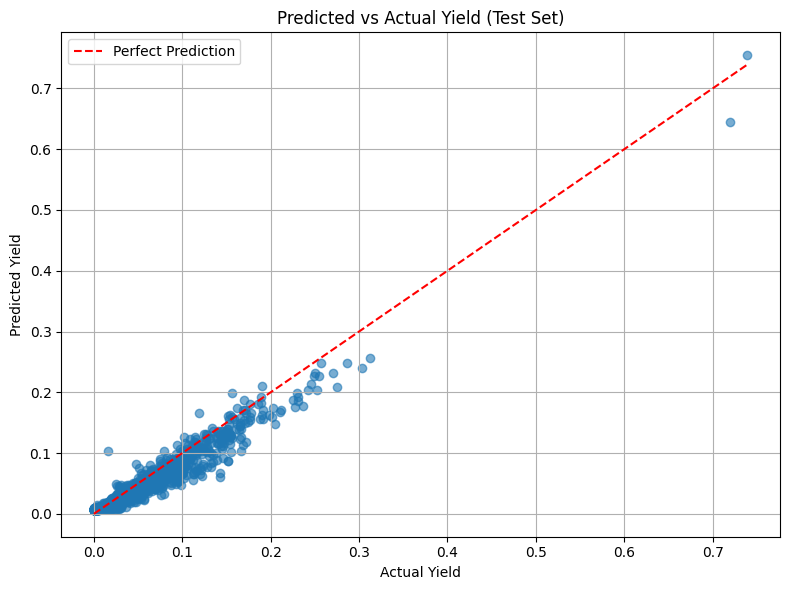

In [25]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.scatter(y_true_test, y_pred_test, alpha=0.6)
plt.plot([y_true_test.min(), y_true_test.max()],
         [y_true_test.min(), y_true_test.max()],
         'r--', label='Perfect Prediction')
plt.xlabel("Actual Yield")
plt.ylabel("Predicted Yield")
plt.title("Predicted vs Actual Yield (Test Set)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [26]:
df['year'] = pd.to_numeric(df['year'], errors='coerce').fillna(0).astype(int)

In [27]:
# Attach predictions and actuals to test_df
test_df['yield_true'] = y_true_rescaled
test_df['yield_pred'] = y_pred_rescaled

# Select key columns for review
results_table = test_df[['year_raw', 'country', 'item', 'yield_true', 'yield_pred']]
results_table = results_table.rename(columns={'year_raw': 'year'})
print(results_table.head(20))

    year      country                                               item  \
0   2021  Afghanistan                                             Apples   
1   2021  Afghanistan                                           Apricots   
2   2021  Afghanistan                                             Barley   
3   2021  Afghanistan                       Cantaloupes and other melons   
4   2021  Afghanistan                                               Figs   
5   2021  Afghanistan                                             Grapes   
6   2021  Afghanistan                                            Linseed   
7   2021  Afghanistan                                       Maize (corn)   
8   2021  Afghanistan                                             Millet   
9   2021  Afghanistan                                       Mustard seed   
10  2021  Afghanistan                                             Olives   
11  2021  Afghanistan                                            Oranges   
12  2021  Af

In [28]:
results_table.to_csv("yield_predictions.csv", index=False)
print("✅ Results saved to 'yield_predictions.csv'")

✅ Results saved to 'yield_predictions.csv'
